# Statistical Learning 

## Class Competition: Netflix Data

## Predictions

 - Week 1: we had an error in script
 - Week 2: we used 2.5 for null values, prediction using Lasso + GBM
 - Week 3: $$user\_avg \cdot user\_prop + movie\_avg \cdot (1-user\_prop) - penalty$$ for nulls.
 - Week 4: Add some more features. 0.7 * lasso + 0.3 * gbm (+ bug fix from prior week)...
 - Week 5: Ensamble model.
 

# Navigation

1. [Get Data](#Get-Data)
1. [New Features](#New-Features)
1. [Fix Nulls](#Fix-Nulls)
1. [Netflix Class](#Netflix-Class)
1. [Modeling](#Modeling)
1. [Prediction](#Prediction)
1. [Data Exploration & Visualisation](#Data-Exploration-&-Visualisation)

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

# from sklearn.preprocessing import Imputer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.decomposition import NMF
# from sklearn.decomposition import TruncatedSVD

# from surprise import evaluate, print_perf, Dataset
# from surprise import SVD, SVDpp

import time

from ggplot import *

## Get Data

[Top](#Navigation)

In [3]:
# read data
X_train = pd.read_csv("Data/X_train.csv")
X_train_dates = pd.read_csv("Data/X_train_dates.csv")
y_train_dates = pd.read_csv("Data/y_train_dates.csv")
y_train_full = pd.read_csv("Data/y_train.csv")

X_test = pd.read_csv("Data/X_test.csv")
X_test_dates = pd.read_csv("Data/X_test_dates.csv")
y_test_dates = pd.read_csv("Data/y_test_dates.csv")

titles = pd.read_csv("Data/titles.csv")

# col names
titles.columns = ['date', 'title']
X_train.columns = titles.title
X_train_dates.columns = titles.title
X_test.columns = titles.title
X_test_dates.columns = titles.title

X_train.head()

title,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,...,Somethings Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook
0,4,4,3,5,4,5,4,4,5,4,...,5,5,4,4,5,5,5,5,0,4
1,4,5,3,3,4,3,4,4,3,2,...,4,4,3,2,3,3,0,3,3,5
2,5,5,5,5,4,5,4,3,4,5,...,5,4,4,0,0,5,5,0,0,0
3,5,5,5,5,4,5,5,3,4,5,...,4,5,5,4,4,2,4,2,2,0
4,5,5,5,5,5,5,5,5,5,5,...,3,0,3,0,2,4,5,4,0,5


## New Features

[Top](#Navigatin)

In [4]:
def new_features(ratings_df, dates_df, y_dates, na_val = 2.5):
    """
    """
    df = ratings_df.copy()
    number_of_ratings_per_user = ratings_df.apply(lambda x : sum(x != 0), axis = 1)
    avg_of_ratings_per_user = ratings_df.apply(lambda x : np.mean(x[x != 0]), axis = 1)
    median_of_ratings_per_user = ratings_df.apply(lambda x : np.median(x[x != 0]), axis = 1)
    sd_of_ratings_per_user = ratings_df.apply(lambda x : np.std(x[x != 0]), axis = 1)
    days_since_first_rating = y_dates.V1 - dates_df.apply(lambda x : min(x[x != 0]), axis = 1) 

    avg_ratings_before = []
    num_ratings_before = []
    avg_ratings_after = []
    num_ratings_after = []

    for i in range(ratings_df.shape[0]):
        tmp_b = ratings_df.iloc[i][(dates_df.iloc[i] <= y_dates.iloc[i].V1)]
        tmp_a = ratings_df.iloc[i][(dates_df.iloc[i] > y_dates.iloc[i].V1)]
        avg_ratings_before.append(np.mean(tmp_b[tmp_b != 0]))
        avg_ratings_after.append(np.mean(tmp_a[tmp_a != 0]))
        num_ratings_before.append(sum(tmp_b != 0))
        num_ratings_after.append(sum(tmp_a != 0))
    
    df['y_dates'] = y_dates.V1
    
    df['number_of_ratings_per_user'] = number_of_ratings_per_user
    df['avg_of_ratings_per_user'] = avg_of_ratings_per_user
    df['median_of_ratings_per_user'] = median_of_ratings_per_user
    df['sd_of_ratings_per_user'] = sd_of_ratings_per_user
    df['days_since_first_rating'] = days_since_first_rating

    df['avg_ratings_before'] = avg_ratings_before
    df['num_ratings_before'] = num_ratings_before
    df['avg_ratings_after'] = avg_ratings_after
    df['num_ratings_after'] = num_ratings_after

    df.fillna(na_val, inplace = True)
    
    return df

## Fix Nulls

[Top](#Navigation)

In [5]:
def na_fix(df, prop_user, penalty, cols):
    """
    Fill null values with avg_rating_user * prop_user + avg_rating_movie * (1 - prop_user) - penalty
    """
    avg_rating_per_movie = df[cols].replace(0, np.nan).mean(skipna = True)
    avg_rating_per_user = df[cols].apply(lambda x : np.mean(x[x != 0]), axis = 1)
    
    na_fix = df.copy()
    for column in cols:
        na_fix[column] = avg_rating_per_user * prop_user + avg_rating_per_movie[column] * (1 - prop_user) - penalty
        
    df_imp = df.copy()
    df_imp = df_imp.where(df_imp[cols] != 0, na_fix[cols]) # fill zeros with new values...
    
    return df_imp

## Netflix Class

All model's and methods...

[Top](#Navigation)

In [6]:
class NetflixPrize:
    """
    Main class for modeling and prediction 
    """
    
    def __init__(self, X_train, y_train, X_test, y_test = None, use_residuals = False, cv = 5):
        """
        Initialize ensamble model
        """
        self.X_train = X_train
        self.y_train = y_train.values.ravel()
        self.X_test = X_test
        if y_test is not None:
            self.y_test = y_test.values.ravel()
        else:
            self.y_test = None
        self.use_residuals = use_residuals
        self.cv = cv
        
    #####################
    # General Functions #
    #####################
    
    def rmse_calc(self, true, pred):
        """
        Calculate RMSE
        """
        return np.sqrt(mean_squared_error(true, pred))
    
    def get_residuals(self, true, pred):
        """
        Get residuals
        """
        return true - pred
        
   
    #########
    # Lasso #
    #########
    
    def lasso_cv_model(self, n_alphas = 200, max_iter = 5000, normalize = True):
        """
        Initialize Lasso model
        """
        self.lasso_cv_model_ = LassoCV(n_alphas = n_alphas, max_iter = max_iter, normalize = normalize)
        return self.lasso_cv_model_
    
    def lasso_cv_fit(self, X_train, y_train, 
                     n_alphas = 200, max_iter = 5000, normalize = True):
        """
        Fit Lasso model
        """
        lasso_mod = self.lasso_cv_model(n_alphas = n_alphas, max_iter = max_iter, normalize = normalize)
        self.lasso_cv_fit_ = lasso_mod.fit(X_train, y_train)
        return self.lasso_cv_fit_
    
    def lasso_cv_predict(self, X_train, y_train, X_test, 
                         n_alphas = 200, max_iter = 5000, normalize = True):
        """
        Predict using Lasso
        """
        lasso_fit = self.lasso_cv_fit(X_train, y_train, n_alphas = n_alphas, 
                                      max_iter = max_iter, normalize = normalize)
        self.lasso_pred_ = lasso_fit.predict(X_test)
        
        # fix
        self.lasso_pred_[self.lasso_pred_ < 1] = 1
        self.lasso_pred_[self.lasso_pred_ > 5] = 5
        
        return self.lasso_pred_
    
    #######
    # GBM #
    #######
    
    def gbm_model(self, learning_rate = .025, n_estimators = 400):
        """
        Initialize GBM model
        """
        self.gbm_model_ = GradientBoostingRegressor(learning_rate = learning_rate, n_estimators = n_estimators)
        return self.gbm_model_
    
    def gbm_fit(self, X_train, y_train, learning_rate = .025, n_estimators = 400):
        """
        Fit GBM model
        """
        gbm_mod = self.gbm_model(learning_rate = learning_rate, n_estimators = n_estimators)
        self.gbm_fit_ = gbm_mod.fit(X_train, y_train)
        return self.gbm_fit_
    
    def gbm_predict(self, X_train, y_train, X_test, 
                    learning_rate = .025, n_estimators = 400):
        """
        Predict using GBM
        """
        gbm_fit = self.gbm_fit(X_train, y_train, learning_rate = learning_rate, n_estimators = n_estimators)
        self.gbm_pred_ = gbm_fit.predict(X_test)
        
        # fix
        self.gbm_pred_[self.gbm_pred_ < 1] = 1
        self.gbm_pred_[self.gbm_pred_ > 5] = 5
        
        return self.gbm_pred_
    
    ######
    # RF #
    ######
    
    def rf_model(self, n_estimators = 100):
        """
        Initialize RF model
        """
        self.rf_model_ = RandomForestRegressor(n_estimators = n_estimators)
        return self.rf_model_
    
    def rf_fit(self, X_train, y_train, n_estimators = 100):
        """
        Fit RF model
        """
        rf_mod = self.rf_model(n_estimators = n_estimators)
        self.rf_fit_ = rf_mod.fit(X_train, y_train)
        return self.rf_fit_
    
    def rf_predict(self, X_train, y_train, X_test, n_estimators = 100):
        """
        Predict using RF
        """
        rf_fit = self.rf_fit(X_train, y_train, n_estimators = n_estimators)
        self.rf_pred_ = rf_fit.predict(X_test)
        
        # fix
        self.rf_pred_[self.rf_pred_ < 1] = 1
        self.rf_pred_[self.rf_pred_ > 5] = 5
        
        return self.rf_pred_
    
    #######
    # PCA #
    #######
    
    def pca_model(self, n_components = 10):
        """
        Fit PCA
        """
        self.pca_model_ = PCA(n_components = n_components)
        
        return self.pca_model_
    
    def pca_fit(self, df_fit, n_components = 10):
        """
        Fit PCA
        """
        pca_model = PCA(n_components = n_components)
        self.pca_fit_ = pca_model.fit(df_fit)
        
        return self.pca_fit_
            
    
    def pca_transform(self, df_transform, df_fit = None, n_components = 10, scale = True):
        """
        PCA transform
        """
        if df_fit is None:
            df_fit = df_transform.copy()
            
        if scale:
            scale = StandardScaler()
            scale_fit = scale.fit(df_fit)
            df_fit = scale_fit.transform(df_fit)
            df_transform = scale_fit.transform(df_transform)
            
        pca_fit = self.pca_fit(df_fit, n_components = n_components)
        pca_df = pca_fit.transform(df_transform)
        
        return pca_df
    
    ########
    # k-NN #
    ########
    
    def knn_model(self, n_neighbors = 100, weights = 'distance', p = 1):
        """
        Initialize k-NN model
        """
        self.knn_model_ = KNeighborsRegressor(n_neighbors = n_neighbors, weights = weights, p = p)
        
        return self.knn_model_
    
    def knn_fit(self, X_train, y_train, n_neighbors = 100, weights = 'distance', p = 1):
        """
        Fit k-NN model
        """
        knn_model = self.knn_model(n_neighbors = n_neighbors, weights = weights, p = p)
        self.knn_fit_ = knn_model.fit(X_train, y_train)
        
        return self.knn_fit_
    
    def knn_predict(self, X_train, y_train, X_test, n_neighbors = 100, weights = 'distance', p = 1):
        """
        Predict using k-NN
        """
        knn_fit = self.knn_fit(X_train, y_train, n_neighbors = n_neighbors, weights = weights, p = p)
        self.knn_pred_ = knn_fit.predict(X_test)
        
        # fix
        self.knn_pred_[self.knn_pred_ < 1] = 1
        self.knn_pred_[self.knn_pred_ > 5] = 5
        
        return self.knn_pred_
    
    ##################
    # ensamble model #
    ##################
    
    def ensamble_model_fit_predict(self, X_train, y_train, X_val, y_val, X_test):
        """
        Fit an ensamble model
        """
        # PCA
        # 10 components
#         pca_X_train_10 = self.pca_transform(X_train)
#         pca_X_val_10 = self.pca_transform(X_val, X_train)
#         pca_X_test_10 = self.pca_transform(X_test, X_train)
        # 40 components
        pca_X_train_40 = self.pca_transform(X_train, n_components = 40)
        pca_X_val_40 = self.pca_transform(X_val, X_train, n_components = 40)
        pca_X_test_40 = self.pca_transform(X_test, X_train, n_components = 40)
        # k-NN
#         knn_val_pred = self.knn_predict(pca_X_train_10, y_train, pca_X_val_10)
#         knn_test_pred = self.knn_predict(pca_X_train_10, y_train, pca_X_test_10)
        # lasso
        lasso_val_pred = self.lasso_cv_predict(X_train, y_train, X_val)
        lasso_test_pred = self.lasso_cv_predict(X_train, y_train, X_test)
        # lasso PCA
        lasso_val_pca_pred = self.lasso_cv_predict(pca_X_train_40, y_train, pca_X_val_40)
        lasso_test_pca_pred = self.lasso_cv_predict(pca_X_train_40, y_train, pca_X_test_40)
        # rf pred
        rf_val_pred = self.rf_predict(X_train, y_train, X_val)
        rf_test_pred = self.rf_predict(X_train, y_train, X_test)
        # rf pred PCA
        rf_val_pca_pred = self.rf_predict(pca_X_train_40, y_train, pca_X_val_40)
        rf_test_pca_pred = self.rf_predict(pca_X_train_40, y_train, pca_X_test_40)
        # gbm pred
        gbm_val_pred = self.gbm_predict(X_train, y_train, X_val)
        gbm_test_pred = self.gbm_predict(X_train, y_train, X_test)
        # gbm pred PCA
        gbm_val_pca_pred = self.gbm_predict(pca_X_train_40, y_train, pca_X_val_40)
        gbm_test_pca_pred = self.gbm_predict(pca_X_train_40, y_train, pca_X_test_40)
        # all
        all_val_pred = pd.DataFrame({#'knn':knn_val_pred, 
                                     'lasso':lasso_val_pred, 
                                     'rf':rf_val_pred, 'gbm':gbm_val_pred, 
                                     'lasso_pca':lasso_val_pca_pred, 'rf_pca':rf_val_pca_pred,
                                     'gbm_pca':gbm_val_pca_pred})

        all_test_pred = pd.DataFrame({#'knn':knn_test_pred, 
                                      'lasso':lasso_test_pred, 
                                      'rf':rf_test_pred, 'gbm':gbm_test_pred, 
                                      'lasso_pca':lasso_test_pca_pred, 'rf_pca':rf_test_pca_pred,
                                      'gbm_pca':gbm_test_pca_pred})
        # final model
        final_lasso_pred = self.lasso_cv_predict(all_val_pred, y_val, all_test_pred)
#         final_elastic_pred = ElasticNetCV(normalize = True).fit(all_val_pred, y_val).predict(all_test_pred) # tmp
        return final_lasso_pred

    def ensamble_model_fit_predict_no_val(self, X_train, y_train, X_test):
        """
        Fit an ensamble model
        """
        # PCA
        # 10 components
#         pca_X_train_10 = self.pca_transform(X_train)
#         pca_X_val_10 = self.pca_transform(X_val, X_train)
#         pca_X_test_10 = self.pca_transform(X_test, X_train)
        # 40 components
        pca_X_train_40 = self.pca_transform(X_train, n_components = 40)
#         pca_X_val_40 = self.pca_transform(X_val, X_train, n_components = 40)
        pca_X_test_40 = self.pca_transform(X_test, X_train, n_components = 40)
        # k-NN
#         knn_val_pred = self.knn_predict(pca_X_train_10, y_train, pca_X_val_10)
#         knn_test_pred = self.knn_predict(pca_X_train_10, y_train, pca_X_test_10)
        # lasso
        lasso_train_pred = self.lasso_cv_predict(X_train, y_train, X_train)
        lasso_test_pred = self.lasso_cv_predict(X_train, y_train, X_test)
        # lasso PCA
        lasso_train_pca_pred = self.lasso_cv_predict(pca_X_train_40, y_train, pca_X_train_40)
        lasso_test_pca_pred = self.lasso_cv_predict(pca_X_train_40, y_train, pca_X_test_40)
        # rf pred
        rf_train_pred = self.rf_predict(X_train, y_train, X_train)
        rf_test_pred = self.rf_predict(X_train, y_train, X_test)
        # rf pred PCA
        rf_train_pca_pred = self.rf_predict(pca_X_train_40, y_train, pca_X_train_40)
        rf_test_pca_pred = self.rf_predict(pca_X_train_40, y_train, pca_X_test_40)
        # gbm pred
        gbm_train_pred = self.gbm_predict(X_train, y_train, X_train)
        gbm_test_pred = self.gbm_predict(X_train, y_train, X_test)
        # gbm pred PCA
        gbm_train_pca_pred = self.gbm_predict(pca_X_train_40, y_train, pca_X_train_40)
        gbm_test_pca_pred = self.gbm_predict(pca_X_train_40, y_train, pca_X_test_40)
        # all
        all_train_pred = pd.DataFrame({#'knn':knn_train_pred, 
                                     'lasso':lasso_train_pred, 
                                     'rf':rf_train_pred, 'gbm':gbm_train_pred, 
                                     'lasso_pca':lasso_train_pca_pred, 'rf_pca':rf_train_pca_pred,
                                     'gbm_pca':gbm_train_pca_pred})

        all_test_pred = pd.DataFrame({#'knn':knn_test_pred, 
                                      'lasso':lasso_test_pred, 
                                      'rf':rf_test_pred, 'gbm':gbm_test_pred, 
                                      'lasso_pca':lasso_test_pca_pred, 'rf_pca':rf_test_pca_pred,
                                      'gbm_pca':gbm_test_pca_pred})
        # final model
        final_lasso_pred = self.lasso_cv_predict(all_train_pred, y_train, all_test_pred)
#         final_elastic_pred = ElasticNetCV(normalize = True).fit(all_val_pred, y_val).predict(all_test_pred) # tmp
        return final_lasso_pred
    
    def ensamble_rmse_cv(self, X_train, y_train, cv = 10, seed = 123):
        """
        Estimate ensamble's model RMSE using CV
        """
        data = X_train.copy()
        data['response'] = y_train

        random_ind = data.index.tolist()
        np.random.seed(seed)
        np.random.shuffle(random_ind) # random row index

        rmse_ = []
#         rmse_elastic = []

        for i, inds in enumerate(np.array_split(random_ind, cv)):
            # split test-train
            X_test = data.loc[data.index.isin(inds), data.columns[:X_train.shape[1]]]
            X_train = data.loc[~data.index.isin(inds), data.columns[:X_train.shape[1]]]
            y_test = data.loc[data.index.isin(inds)].response
            y_train = data.loc[~data.index.isin(inds)].response
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .5)
            # predict
            pred = self.ensamble_model_fit_predict(X_train, y_train, X_val, y_val, X_test)
            
            rmse_.append(self.rmse_calc(y_test, pred))
#             rmse_elastic.append(self.rmse_calc(y_test, pred_elastic))
            
            #, np.mean(rmse_elastic)
        return np.mean(rmse_)
    
    def ensamble_rmse_cv_no_val(self, X_train, y_train, cv = 10, seed = 123):
        """
        Estimate ensamble's model RMSE using CV
        """
        data = X_train.copy()
        data['response'] = y_train

        random_ind = data.index.tolist()
        np.random.seed(seed)
        np.random.shuffle(random_ind) # random row index

        rmse_ = []
#         rmse_elastic = []

        for i, inds in enumerate(np.array_split(random_ind, cv)):
            # split test-train
            X_test = data.loc[data.index.isin(inds), data.columns[:X_train.shape[1]]]
            X_train = data.loc[~data.index.isin(inds), data.columns[:X_train.shape[1]]]
            y_test = data.loc[data.index.isin(inds)].response
            y_train = data.loc[~data.index.isin(inds)].response
#             X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .5)
            # predict
            pred = self.ensamble_model_fit_predict_no_val(X_train, y_train, X_test)
            
            rmse_.append(self.rmse_calc(y_test, pred))
#             rmse_elastic.append(self.rmse_calc(y_test, pred_elastic))
            
            #, np.mean(rmse_elastic)
        return np.mean(rmse_)
    
    def ensamble_predict(self, X_train, y_train, X_test, val_frac = .1, seed = 0):
        """
        Predict using ensamble model
        """
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_frac, 
                                                          random_state = seed)
        
        pred = self.ensamble_model_fit_predict(X_train, y_train.values.ravel(), X_val, y_val.values.ravel(), X_test)
        
        pred[pred > 5] = 5
        pred[pred < 1] = 1
        
        return pred

## Modeling

[Top](#Navigation)

In [6]:
# X_train.drop(['set'], axis = 1, inplace = True)
# X_test.drop(['set'], axis = 1, inplace = True)

In [7]:
##################################
# Add new features and Fix nulls #
##################################

## New Features
X_train_full = new_features(X_train, X_train_dates, y_train_dates)
X_test_full = new_features(X_test, X_test_dates, y_test_dates)
## Fix Nulls in test and train
X_train['set'] = 'train'
X_test['set'] = 'test'
all_rankings_data = X_train.append(X_test, ignore_index = True)
# params - Note that prop_user = .9 and penalty = 1.5 got smallest RMSE using CV and Lasso for prediction...
prop_user = .7
penalty = 1.5
all_rankings_data_na_fix = na_fix(all_rankings_data, prop_user, penalty, titles.title)
X_train_na_fix = all_rankings_data_na_fix.loc[all_rankings_data.set == 'train']
X_test_na_fix = all_rankings_data_na_fix.loc[all_rankings_data.set == 'test']

X_train.drop(['set'], axis = 1, inplace = True)
X_test.drop(['set'], axis = 1, inplace = True)

X_train_full_na_fix = X_train_na_fix.drop(['set'], axis = 1).copy()
X_test_full_na_fix = X_test_na_fix.drop(['set'], axis = 1).copy()

new_features_ = [col for col in X_train_full.columns if col not in X_train_na_fix.columns]

X_train_full_na_fix = pd.concat([X_train_full_na_fix.reset_index(drop = True), 
                                 X_train_full[new_features_].reset_index(drop = True)], axis = 1)

X_test_full_na_fix = pd.concat([X_test_full_na_fix.reset_index(drop = True), 
                                 X_test_full[new_features_].reset_index(drop = True)], axis = 1)

In [116]:
netflix = NetflixPrize(X_train_full_na_fix, y_train_full, X_test_full_na_fix, cv = 5)

In [95]:
start = time.time()
rmse_ = netflix.ensamble_rmse_cv(netflix.X_train, netflix.y_train, seed = 111)
end = time.time()
print ("Estimated RMSE is %f" % rmse_)

Estimated RMSE is 0.756319


In [96]:
(end - start) / 60

12.349937832355499

In [ ]:
# no validation!!

In [118]:
start = time.time()
rmse_ = netflix.ensamble_rmse_cv_no_val(netflix.X_train, netflix.y_train, seed = 111, cv = 5)
end = time.time()
print ("Estimated RMSE is %f" % rmse_)

Estimated RMSE is 0.786041


In [119]:
(end - start) / 60

12.57464109659195

In [ ]:
## Nulls to 2.5

In [122]:
X_train_simple_na_fix = X_train.replace(0, np.nan).fillna(2.5)
X_test_simple_na_fix = X_test.replace(0, np.nan).fillna(2.5)

In [123]:
X_train_full_simple_na_fix = pd.concat([X_train_simple_na_fix.reset_index(drop = True), 
                                 X_train_full[new_features_].reset_index(drop = True)], axis = 1)

X_test_full_simple_na_fix = pd.concat([X_test_simple_na_fix.reset_index(drop = True), 
                                 X_test_full[new_features_].reset_index(drop = True)], axis = 1)

In [127]:
netflix = NetflixPrize(X_train_full_simple_na_fix, y_train_full, X_test_full_simple_na_fix, cv = 5)
start = time.time()
rmse_ = netflix.ensamble_rmse_cv(netflix.X_train, netflix.y_train, seed = 111, cv = 10)
end = time.time()
print ("Estimated RMSE is %f" % rmse_)

Estimated RMSE is 0.758576


In [128]:
(end - start) / 60

18.9938162167867

## Prediction

[Top](#Navigation)

In [135]:
netflix = NetflixPrize(X_train_full_na_fix, y_train_full, X_test_full_na_fix)
predictions = pd.DataFrame()

for i in range(10):
    print (i + 1)
    pred = netflix.ensamble_predict(X_train_full_na_fix, y_train_full, X_test_full_na_fix, 
                                    val_frac = .1, seed = i * 10)
    predictions['pred_%d' % i] = pred

1
2
3
4
5
6
7
8
9
10


In [138]:
predictions.head(10)

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
0,5.000000,5.000000,5.000000,4.952079,4.867215,4.894441,4.958005,4.999203,4.966142,4.941522
1,5.000000,5.000000,5.000000,4.928665,4.840012,4.938594,4.964162,4.991737,5.000000,4.952844
2,3.103100,3.061178,2.991971,3.099341,3.123689,3.020493,3.111426,3.129096,3.047231,3.139464
3,3.141898,3.142936,3.054900,3.183184,3.161547,3.143621,3.150226,3.225303,3.171621,3.201327
4,3.282169,3.247648,3.212739,3.287590,3.237950,3.263518,3.248741,3.317130,3.264996,3.291744
5,3.192280,3.205716,3.222601,3.176503,3.188028,3.179415,3.169375,3.238943,3.270742,3.259645
6,4.252724,4.177751,4.218696,4.176834,4.092486,4.285128,4.192825,4.265337,4.354915,4.243898
7,4.359318,4.305100,4.290595,4.261753,4.237532,4.137355,4.298715,4.324136,4.415197,4.233309
8,3.478512,3.474535,3.494546,3.464010,3.472875,3.514889,3.464703,3.507856,3.562883,3.483843
9,2.963990,2.936081,2.874806,2.957390,3.014482,2.810710,2.910603,3.014055,2.933609,3.000782


In [139]:
mean_pred = predictions.mean(axis = 1)

In [141]:
mean_pred.to_csv("Data/Prediction_26_4.csv", index = False)

In [140]:
# ggplot(y_train_full, aes('V1')) + geom_density()

## Data Exploration & Visualisation

[Top](#Navigation)

In [40]:
# change to a long format
X_train_for_vis = X_train.copy()
X_train_dates_for_vis = X_train_dates.copy()
X_train_for_vis['user_id'] = range(X_train_for_vis.shape[0])
X_train_dates_for_vis['user_id'] = range(X_train_for_vis.shape[0])

In [41]:
X_train_for_vis_melted = pd.melt(X_train_for_vis, id_vars=['user_id'])
X_train_for_vis_melted.columns = ['user_id', 'movie', 'rating']
X_train_dates_for_vis_melted = pd.melt(X_train_dates_for_vis, id_vars=['user_id'])
X_train_dates_for_vis_melted.columns = ['user_id', 'movie', 'date']

In [42]:
all_train_data_for_vis = X_train_for_vis_melted.merge(X_train_dates_for_vis_melted, 
                                                      on = ['user_id', 'movie'])

In [43]:
all_train_data_for_vis.head()

,user_id,movie,rating,date
0,0,Independence Day,4,2544
1,1,Independence Day,4,2656
2,2,Independence Day,5,2381
3,3,Independence Day,5,1404
4,4,Independence Day,5,2428


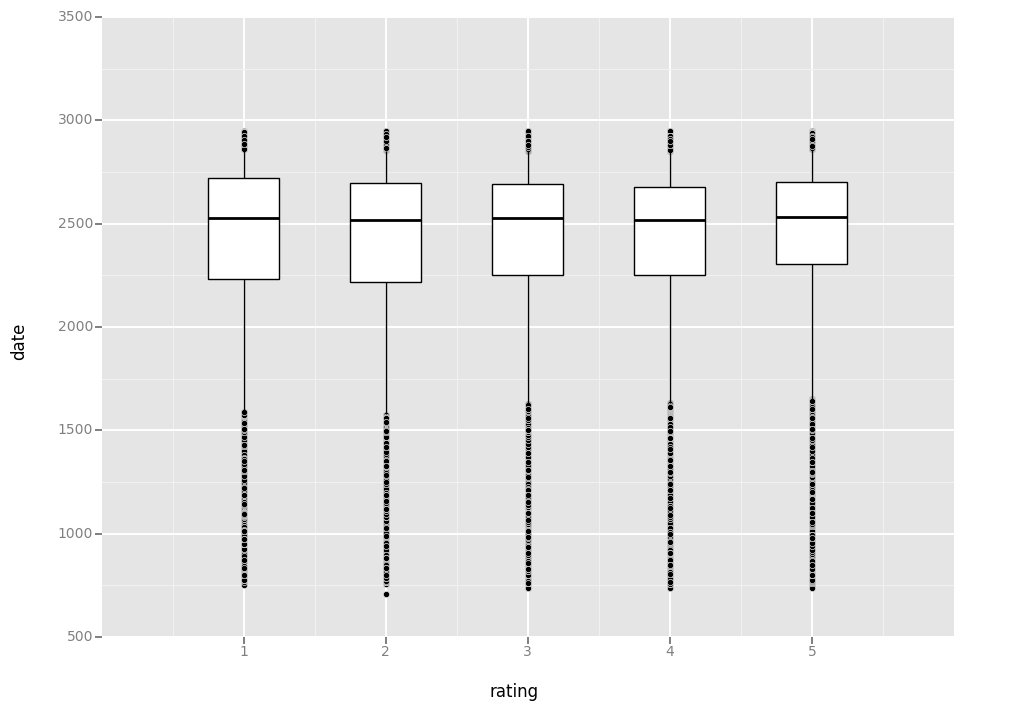

<ggplot: (-9223372036564130928)>

In [36]:
ggplot(all_train_data_for_vis.loc[all_train_data_for_vis.rating != 0], 
       aes('rating', 'date')) + geom_boxplot()

In [37]:
# correlation netween date and rating
tmp = all_train_data_for_vis.loc[all_train_data_for_vis.rating != 0]
np.corrcoef(tmp.rating, tmp.date)

array([[ 1.        ,  0.02678506],
       [ 0.02678506,  1.        ]])

In [45]:
# same date ratings...
tmp_date = X_train_dates.copy()
tmp_date['y_dates'] = y_train_dates

tmp = tmp_date.apply(lambda x : sum(x == x.y_dates), axis = 1)

In [50]:
# pct of user with ratings at same date of our movie - train data
(tmp > 1).mean()

0.0264

In [53]:
tmp.mean()

1.0851

In [55]:
# tmp[tmp > 1]

In [60]:
# X_train.iloc[496][X_train_dates.iloc[496] == 2354]

In [49]:
# same date ratings...
tmp_test_date = X_test_dates.copy()
tmp_test_date['y_dates'] = y_test_dates
# pct of user with ratings at same date of our movie - test data
(tmp_test_date.apply(lambda x : sum(x == x.y_dates), axis = 1) > 1).mean()

0.93039918116683729

In [52]:
tmp_test_date.apply(lambda x : sum(x == x.y_dates), axis = 1).mean()

21.24292050494712

In [ ]:
tmp_test_date.apply(lambda x : sum(x == x.y_dates), axis = 1).mean()

In [68]:
X_test.std(axis = 1).mean()

1.5677731199154123

## ToDo

- Reapet and avg ?